In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Use 64 bit precision for JAX
jax.config.update("jax_enable_x64", True)

In [2]:
# Create a 2d function
def f(x):
    return jnp.sin(x[0]*x[1])

In [3]:
x_range=(-2, 2)
y_range=(-2, 2)
n=100
x = jnp.linspace(x_range[0], x_range[1], n)
y = jnp.linspace(y_range[0], y_range[1], n)
X, Y = jnp.meshgrid(x, y)

In [4]:
# Evaluate the function at a grid of points using vmap
def eval_grid(f, x_range=(-2, 2), y_range=(-2, 2), n=100):
    x = jnp.linspace(x_range[0], x_range[1], n)
    y = jnp.linspace(y_range[0], y_range[1], n)
    X, Y = jnp.meshgrid(x, y)
    return X, Y, jax.vmap(jax.vmap(f, in_axes=0), in_axes=0)(jnp.stack([X, Y], axis=-1))

In [5]:
# Plot the contour of the function
def plot_contour(f, x_range=(-2, 2), y_range=(-2, 2), n=100, ax = None, **kwargs):
    X, Y, Z = eval_grid(f, x_range, y_range, n)
    if ax is None:
        fig, ax = plt.subplots()
        
    levels = jnp.linspace(-1.0, int(jnp.max(Z))+0.5, 11)
    contours = ax.contour(X, Y,Z, levels=levels, **kwargs)
    ax.clabel(contours, inline=True, fontsize=8)

    #ax.imshow(Z, extent= [X.min(), X.max(), Y.min(), Y.max()], origin='lower', cmap='viridis', alpha=0.5)
    return ax

<AxesSubplot: >

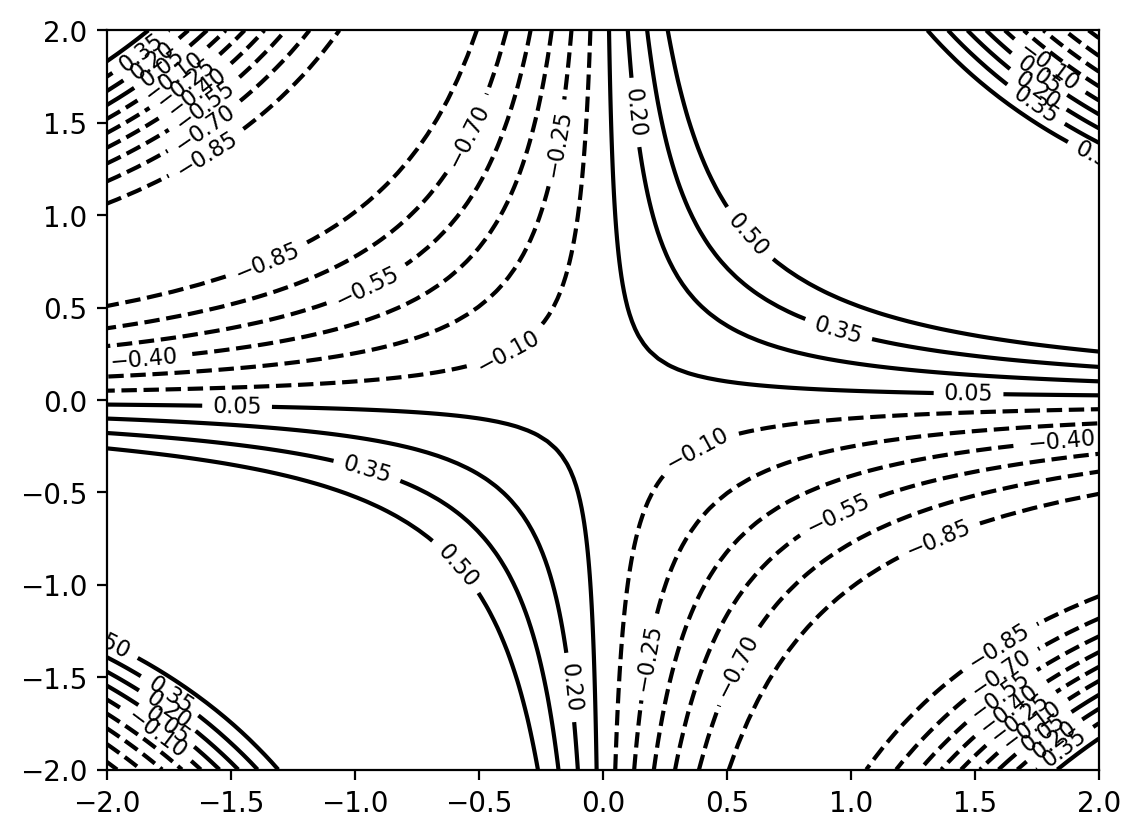

In [6]:
plot_contour(f, colors='k')

In [7]:
# Plot surface of the function
def plot_surface(f, x_range=(-2, 2), y_range=(-2, 2), n=100, ax = None, **kwargs):
    X, Y, Z = eval_grid(f, x_range, y_range, n)

    if ax is None:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        
    ax.plot_surface(X, Y, Z, **kwargs)
    return ax

In [31]:
# Plot surface in Plotly
import plotly.graph_objects as go

def plot_surface_plotly(f, x_range=(-2, 2), y_range=(-2, 2), n=100, **kwargs):
    X, Y, Z = eval_grid(f, x_range, y_range, n)
    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, **kwargs)])
    fig.update_layout(scene = dict(
                    xaxis_title='x',
                    yaxis_title='y',
                    zaxis_title='z'))
    

    
    fig.show()

<Axes3DSubplot: >

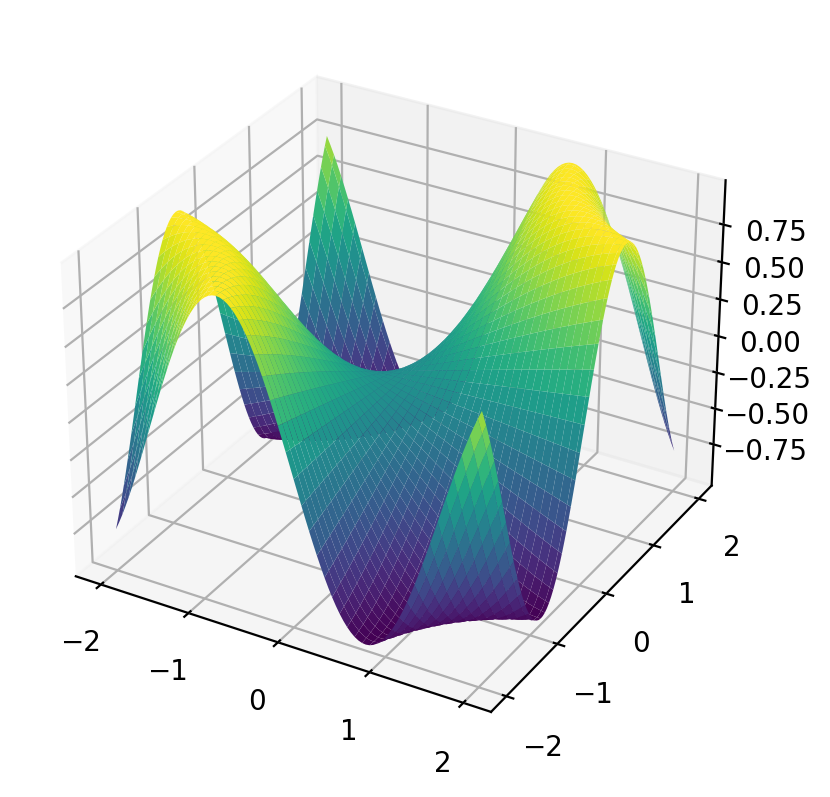

In [32]:
plot_surface(f, cmap='viridis')

In [33]:
plot_surface_plotly(f)

In [9]:
g = jax.grad(f)
H = jax.hessian(f)

In [10]:
jnp.array(g([1.0, 1.0]))

Array([0.54030231, 0.54030231], dtype=float64)

In [11]:
jnp.array(H([1.0, 1.0]))

Array([[-0.84147098, -0.30116868],
       [-0.30116868, -0.84147098]], dtype=float64)

In [12]:
print(type(f([1.0, 1.0])), type(jnp.array(g([1.0, 1.0]))), type(H([1.0, 1.0])))

<class 'jaxlib.xla_extension.Array'> <class 'jaxlib.xla_extension.Array'> <class 'list'>


In [13]:
# First order Taylor approximation around x0
def taylor1(f, x0):
    g = jax.grad(f)
    t = lambda x: f(x0) + jnp.array(g(x0)) @ (x - x0)
    # Print the Taylor approximation
    print("f(x) = {:.2f} + {:.2f} (x1 - {:.2f}) + {:.2f} (x2 - {:.2f})".format(f(x0), g(x0)[0], x0[0], g(x0)[1], x0[1]))
    
    return t

In [14]:
taylor1(f, jnp.array([1.0, 1.0]))(jnp.array([0.0, 1.0]))

f(x) = 0.84 + 0.54 (x1 - 1.00) + 0.54 (x2 - 1.00)


Array(0.30116868, dtype=float64)

In [15]:
# Second order Taylor approximation around x0
def taylor2(f, x0):
    g = jax.grad(f)
    H = jax.hessian(f)
    t = lambda x: f(x0) + jnp.array(g(x0)) @ (x - x0) + 0.5*(x - x0) @ jnp.array(H(x0)) @ (x - x0)
    # Print the Taylor approximation
    print("f(x) = {:.2f} + {:.2f} (x1 - {:.2f}) + {:.2f} (x2 - {:.2f}) + {:.2f} (x1 - {:.2f})^2 + {:.2f} (x2 - {:.2f})^2 + {:.2f} (x1 - {:.2f})(x2 - {:.2f})".format(f(x0), g(x0)[0], x0[0], g(x0)[1], x0[1], H(x0)[0, 0], x0[0], H(x0)[1, 1], x0[1], H(x0)[0, 1], x0[0], x0[1]))
    
    return t

In [16]:
taylor2(f, jnp.array([1.0, 1.0]))(jnp.array([0.0, 1.0]))

f(x) = 0.84 + 0.54 (x1 - 1.00) + 0.54 (x2 - 1.00) + -0.84 (x1 - 1.00)^2 + -0.84 (x2 - 1.00)^2 + -0.30 (x1 - 1.00)(x2 - 1.00)


Array(-0.11956681, dtype=float64)

In [17]:
H(jnp.array([1.0, 1.0]))

Array([[-0.84147098, -0.30116868],
       [-0.30116868, -0.84147098]], dtype=float64)

In [18]:
g(jnp.array([1.0, 1.0]))

Array([0.54030231, 0.54030231], dtype=float64)

In [19]:
# Plot contour of the Taylor approximation around x0 for both first and second order in comparison with the original function
# 3 subplots
def plot_taylor(f, x0, x_range=(-2, 2), y_range=(-2, 2), n=100, ax = None):
    t1 = taylor1(f, x0)
    t2 = taylor2(f, x0)
    
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Mark the point x0
    ax[0].scatter(x0[0], x0[1], marker='x', color='red', s=100)

    # Plot the contour of the function
    plot_contour(f, x_range, y_range, n, ax=ax[0], colors='black')

    # Plot the contour of the first order Taylor approximation
    plot_contour(t1, x_range, y_range, n, ax=ax[1], colors='black')
    ax[1].scatter(x0[0], x0[1], marker='x', color='red', s=100)

    # Plot the contour of the second order Taylor approximation
    plot_contour(t2, x_range, y_range, n, ax=ax[2], colors='black')
    ax[2].scatter(x0[0], x0[1], marker='x', color='red', s=100)


f(x) = 0.84 + 0.54 (x1 - 1.00) + 0.54 (x2 - 1.00)
f(x) = 0.84 + 0.54 (x1 - 1.00) + 0.54 (x2 - 1.00) + -0.84 (x1 - 1.00)^2 + -0.84 (x2 - 1.00)^2 + -0.30 (x1 - 1.00)(x2 - 1.00)


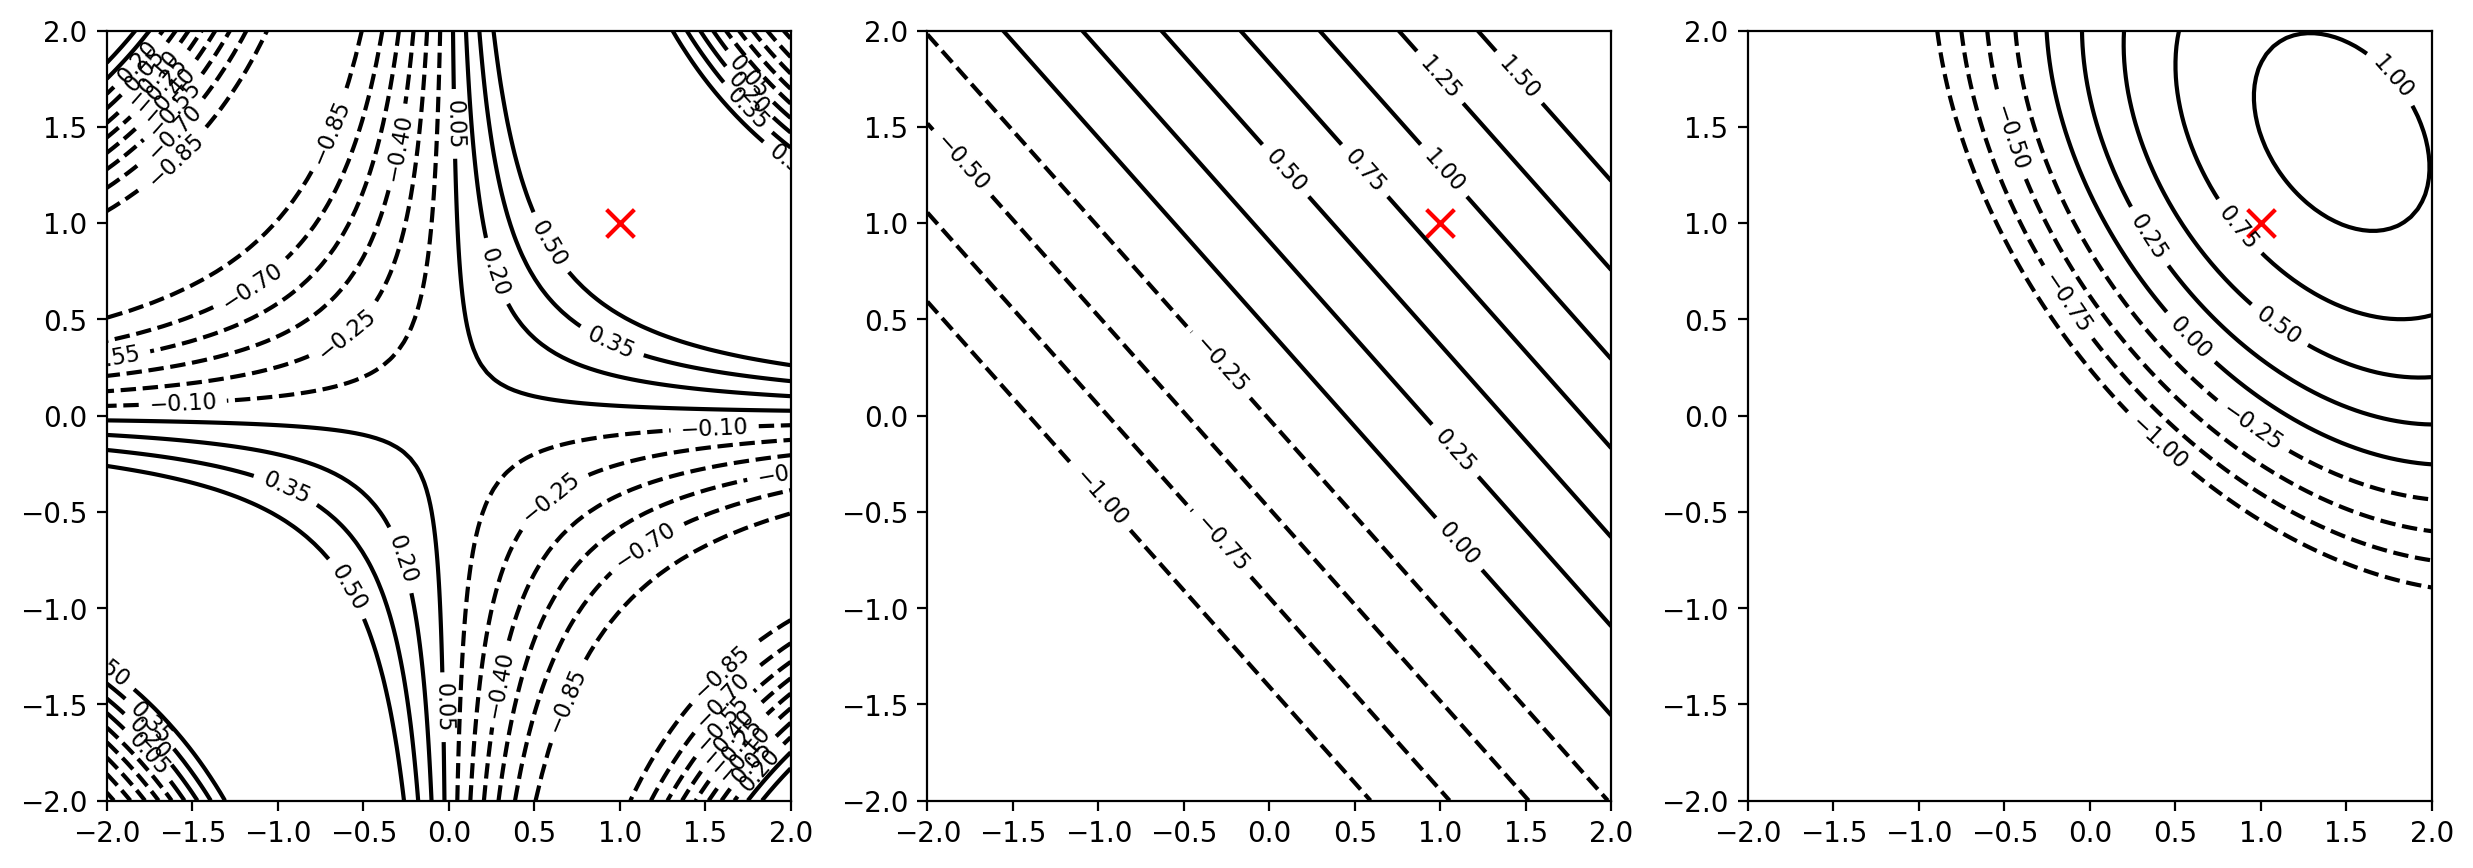

In [20]:
plot_taylor(f, jnp.array([1.0, 1.0]))

In [21]:
# Plot surface of the Taylor approximation around x0 for both first and second order in comparison with the original function
# 3 subplots

def plot_taylor_surface(f, x0, x_range=(-2, 2), y_range=(-2, 2), n=100, ax = None):
    t1 = taylor1(f, x0)
    t2 = taylor2(f, x0)
    
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": "3d"})
    
    # Mark the point x0
    ax[0].scatter(x0[0], x0[1], f(x0), marker='x', color='red', s=100)

    # Plot the surface of the function
    plot_surface(f, x_range, y_range, n, ax=ax[0])

    # Plot the surface of the first order Taylor approximation
    plot_surface(t1, x_range, y_range, n, ax=ax[1])
    ax[1].scatter(x0[0], x0[1], f(x0), marker='x', color='red', s=100)

    # Plot the surface of the second order Taylor approximation
    plot_surface(t2, x_range, y_range, n, ax=ax[2])
    ax[2].scatter(x0[0], x0[1], f(x0), marker='x', color='red', s=100)

f(x) = 0.84 + 0.54 (x1 - 1.00) + 0.54 (x2 - 1.00)
f(x) = 0.84 + 0.54 (x1 - 1.00) + 0.54 (x2 - 1.00) + -0.84 (x1 - 1.00)^2 + -0.84 (x2 - 1.00)^2 + -0.30 (x1 - 1.00)(x2 - 1.00)


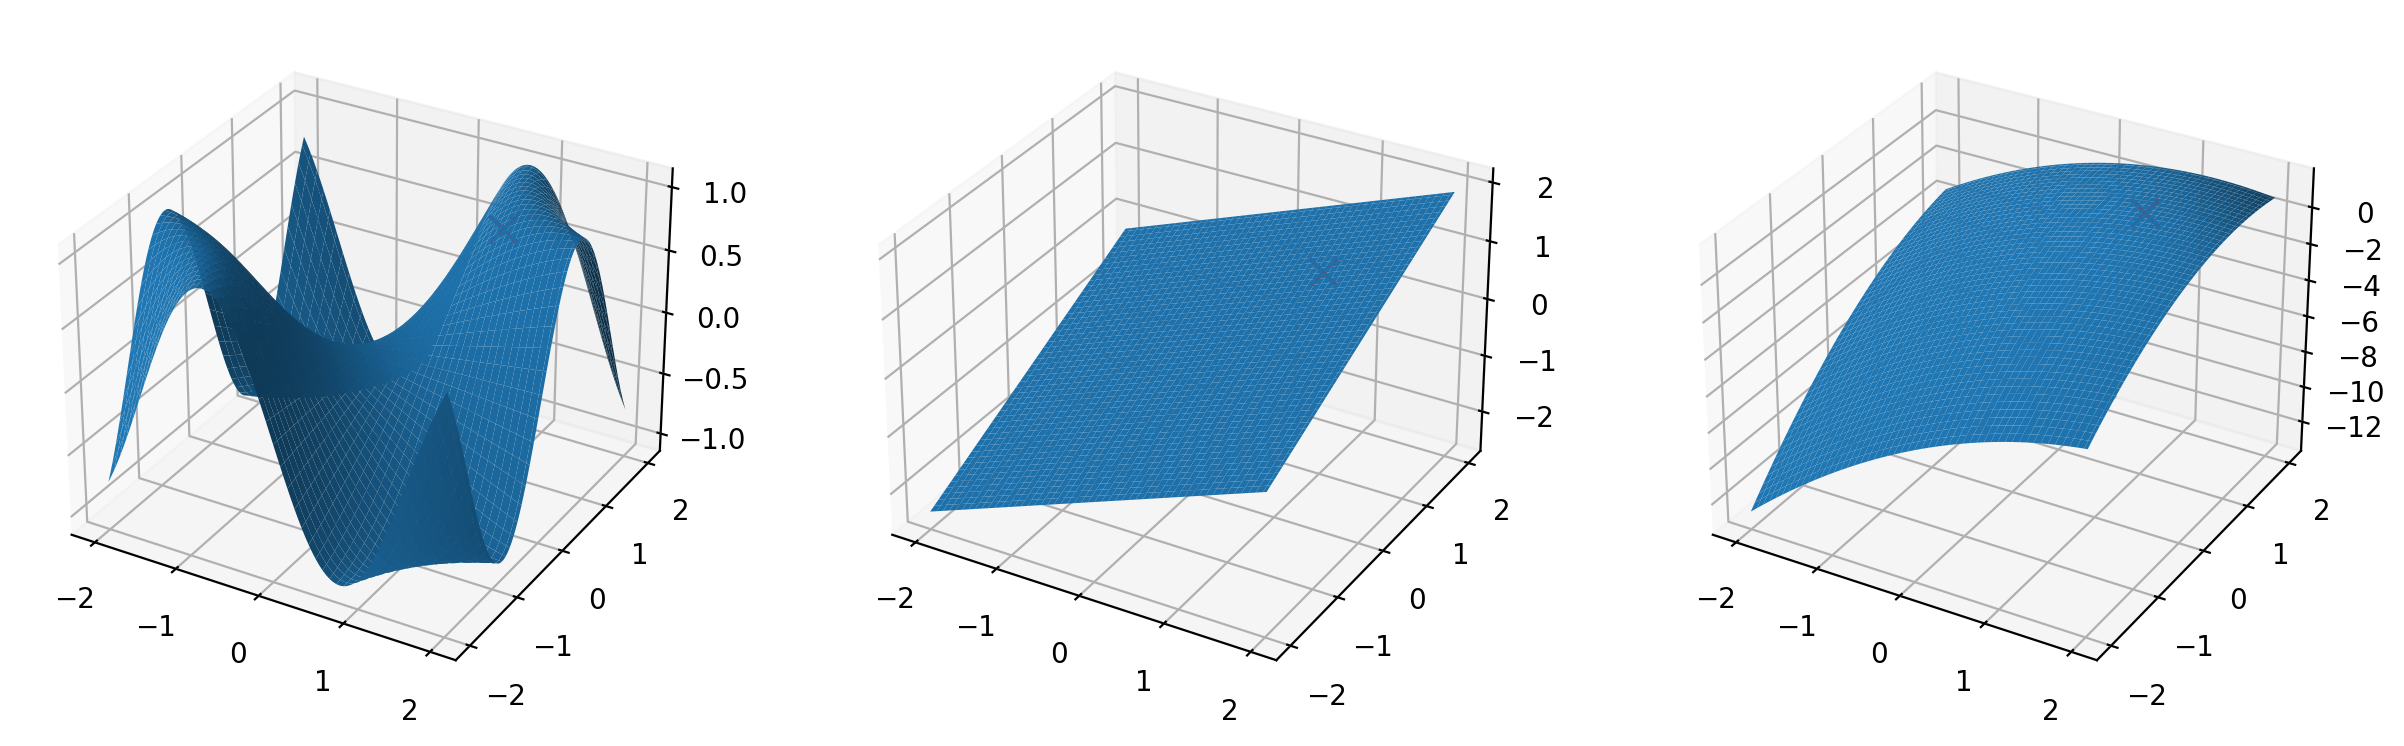

In [22]:
plot_taylor_surface(f, jnp.array([1.0, 1.0]))

Second order Taylor series expansion of a function f around a point (x0, y0) is given by (when using the vector notation)

$$f(x,y) = f(x_0,y_0) + \frac{\partial f}{\partial x}(x_0,y_0)(x-x_0) + \frac{\partial f}{\partial y}(x_0,y_0)(y-y_0) + \frac{1}{2} \frac{\partial^2 f}{\partial x^2}(x_0,y_0)(x-x_0)^2 + \frac{1}{2} \frac{\partial^2 f}{\partial y^2}(x_0,y_0)(y-y_0)^2 + \frac{1}{2} \frac{\partial^2 f}{\partial x \partial y}(x_0,y_0)(x-x_0)(y-y_0)$$